사실 많은 분들이 “모델이 알아서 Feature Importance 뽑아주는데, 그럼 EDA는 왜 하지?”라고 물어보거든요.

🔎 EDA를 하는 이유

데이터 이해 (현업 관점)

모델 돌리기 전에 데이터의 기본 구조를 파악

예: 고객 이탈율이 27%밖에 안 된다는 사실 → 불균형 데이터 문제 확인

tenure 분포, 요금대 분포 → 비즈니스 감각 생김

데이터 품질 점검

결측치, 이상치, 잘못된 값 확인

예: TotalCharges에 공백 → 숫자 변환 필요 (coerce)

변수와 Target의 관계 직관적으로 확인

tenure 짧으면 이탈 ↑

Month-to-month 계약이면 이탈 ↑

→ 현업에서도 “맞아, 우리도 그렇게 생각했어”라고 공감할 수 있음

👉 모델은 블랙박스일 수 있지만, EDA는 설명용 & 검증용

Feature Engineering 아이디어

EDA 과정에서 “이 변수 합치면 의미 있겠다” 같은 힌트 얻음

예: MonthlyCharges × tenure ≈ TotalCharges

발표/스토리텔링에 꼭 필요

단순히 “모델이 Contract 중요하대요” 하는 것보다,

“EDA에서도 Month-to-month 계약 고객이 실제로 이탈율이 높았습니다” 하면 훨씬 설득력 ↑

✅ 정리

EDA = 데이터의 직관적인 1차 해석 (현업 설득용 + 데이터 점검)

Feature Importance = 모델이 학습한 실제 기여도 (예측력 중심)

👉 즉, EDA는 "사전 지도", **모델은 "최종 내비게이션"**이라고 생각하시면 돼요 🚗💡


📊 Churn EDA vs Feature Importance
🔎 EDA 인사이트 (단변수 기준)

tenure: 짧을수록 이탈 ↑

MonthlyCharges: 높을수록 이탈 ↑

TotalCharges: 장기 고객은 총 지출 많음 → 이탈 ↓

Contract: Month-to-month 계약 → 이탈 ↑

PaymentMethod: Electronic check → 이탈 ↑

TechSupport/OnlineSecurity: No인 경우 → 이탈 ↑

👉 단독 변수와 Churn 관계만 반영 → 직관적, 단순한 패턴 확인

🔎 Feature Importance (모델 기준, RandomForest)

가장 중요한 변수:

Contract=Month-to-month

PaymentMethod=Electronic check

OnlineSecurity=No, TechSupport=No

그 다음 중요 변수:

tenure, TotalCharges, MonthlyCharges

👉 모델이 실제 예측에서 얼마나 활용했는지 반영 → 변수 간 상호작용 고려

✅ 차이 발생 이유

EDA: 단일 변수 기준 (상호작용·중복 설명 고려 X)

Feature Importance: 모델이 학습한 실제 기여도 (여러 변수 동시 고려)

예:

tenure와 TotalCharges는 서로 상관이 높아 → 모델은 일부만 중요하게 씀

계약·서비스·결제 조건은 고객 행동을 더 직접적으로 나누는 기준이라 → 중요도가 더 높게 평가

📌 발표 멘트 예시

“EDA에서는 기간과 요금이 이탈과 밀접하게 보였지만,
실제 모델에서는 계약·결제·서비스 조건이 더 큰 영향을 주는 것으로 나타났습니다.
이는 단순 통계와 머신러닝 모델의 해석 차이를 보여주며,
비즈니스 전략 수립 시 두 가지 관점을 함께 참고해야 합니다.”

👉 원하시면 제가 이걸 Streamlit 탭 구조로 넣어서, 발표할 때 EDA 그래프와 Feature Importance 그래프를 나란히 보여주는 데모 코드도 짜드릴까요?

**1. Importing the dependencies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

**2. Data Loading and Understanding**

In [3]:
# load teh csv data to a pandas dataframe
df = pd.read_csv("customer_Info copy.csv")

In [4]:
df.shape

(7043, 21)

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
pd.set_option("display.max_columns", None)

In [7]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
# dropping customerID column as this is not required for modelling
df = df.drop(columns=["customerID"])

In [10]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [11]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [12]:
print(df["gender"].unique())

['Female' 'Male']


In [13]:
print(df["SeniorCitizen"].unique())

[0 1]


In [14]:
# printing the unique values in all the columns

numerical_features_list = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in df.columns:
  if col not in numerical_features_list:
    print(col, df[col].unique())
    print("-"*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet 

In [15]:
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [16]:
#df["TotalCharges"] = df["TotalCharges"].astype(float)

In [17]:
df[df["TotalCharges"]==" "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [18]:
len(df[df["TotalCharges"]==" "])

11

In [19]:
df["TotalCharges"] = df["TotalCharges"].replace({" ": "0.0"})

In [20]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [22]:
# checking the class distribution of target column
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


**Insights:**
1. Customer ID removed as it is not required for modelling
2. No mmissing values in the dataset
3. Missing values in the TotalCharges column were replaced with 0
4. Class imbalance identified in the target

**3. Exploratory Data Analysis (EDA)**

In [23]:
df.shape

(7043, 20)

In [24]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [25]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [26]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [27]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 저장 폴더 만들기
save_dir = "notebook/eda_insight"
os.makedirs(save_dir, exist_ok=True)

# 1) 수치형 인사이트 → MonthlyCharges vs Churn (Boxplot)
plt.figure(figsize=(7,5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("MonthlyCharges vs Churn")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "insight1_boxplot.png"), bbox_inches="tight")
plt.close()

# 2) 범주형 인사이트 → Contract vs Churn Rate (Barplot)
contract_churn = df.groupby("Contract")["Churn"].apply(lambda x: (x=="Yes").mean())
plt.figure(figsize=(7,5))
contract_churn.plot(kind="bar", color="tomato")
plt.title("Contract vs Churn Rate")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "insight2_barplot.png"), bbox_inches="tight")
plt.close()

# 3) 상관관계 인사이트 → Heatmap
df_corr = df[["tenure","MonthlyCharges","TotalCharges","Churn"]].copy()
df_corr["Churn"] = df_corr["Churn"].replace({"Yes":1,"No":0})
plt.figure(figsize=(7,5))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "insight3_corr.png"), bbox_inches="tight")
plt.close()


C:\Users\honor\AppData\Local\Temp\ipykernel_8776\2856000343.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_corr["Churn"] = df_corr["Churn"].replace({"Yes":1,"No":0})


1) 인사이트

tenure: 짧을수록 이탈 ↑

MonthlyCharges: 높을수록 이탈 ↑

TotalCharges: 장기 고객은 총 지출 많음 → 이탈 ↓

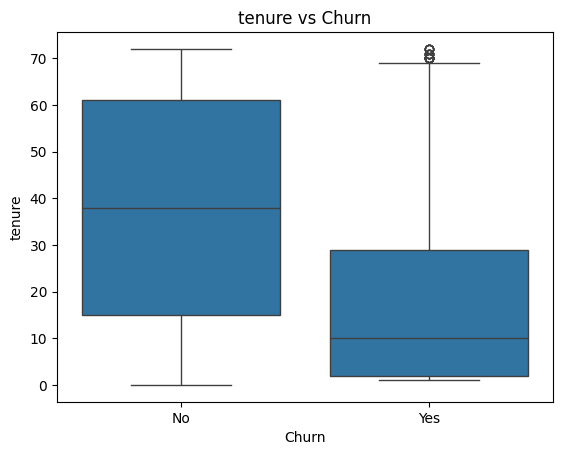

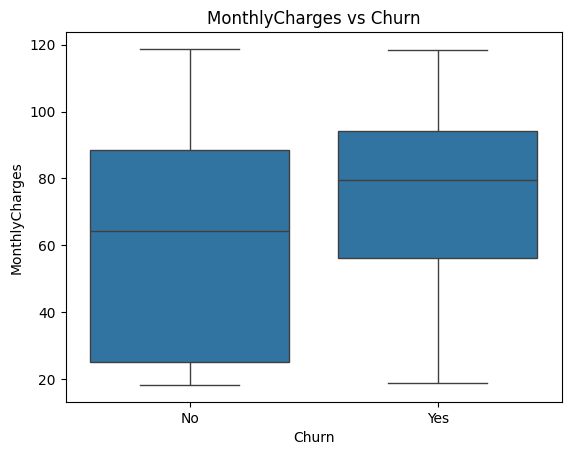

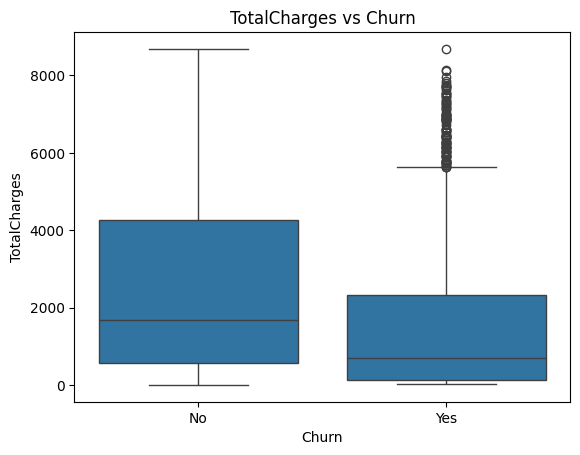

In [28]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()

2. 인사이트


Contract: Month-to-month 계약 → 이탈율 높음

PaymentMethod: Electronic check → 이탈율 높음

TechSupport/OnlineSecurity: No인 경우 → 이탈율 높음

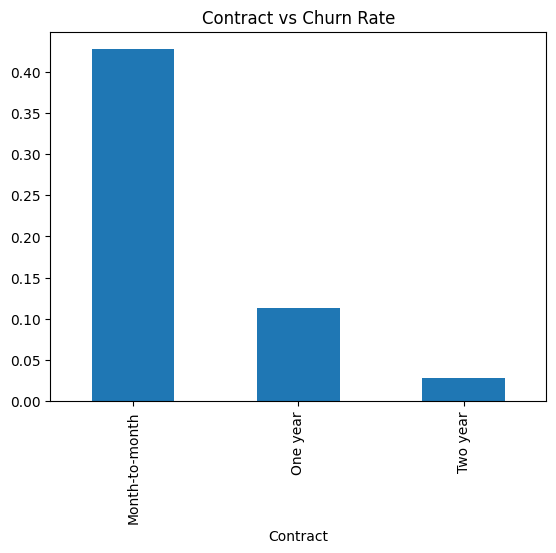

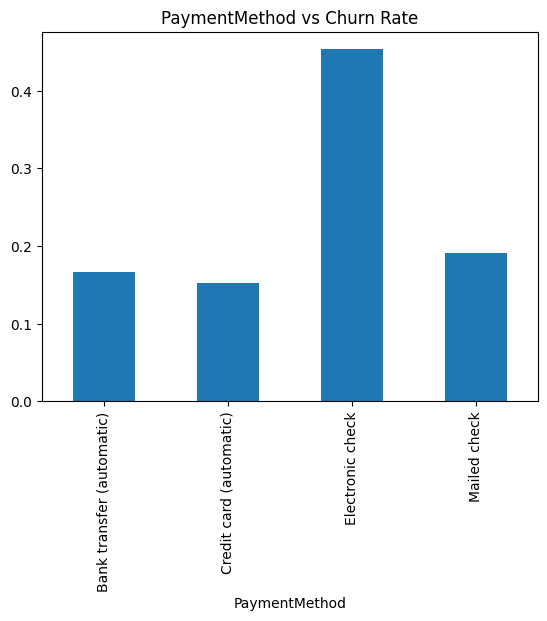

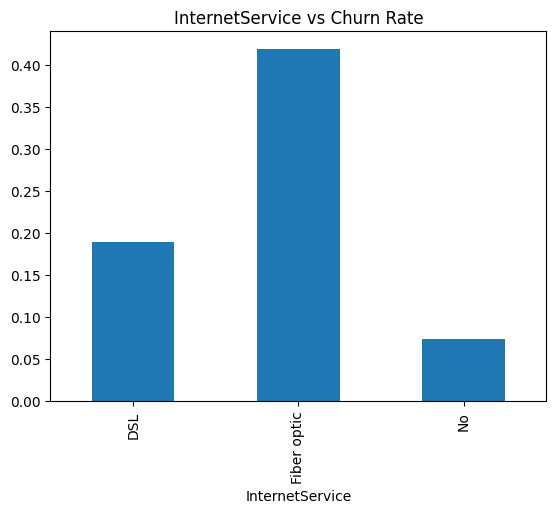

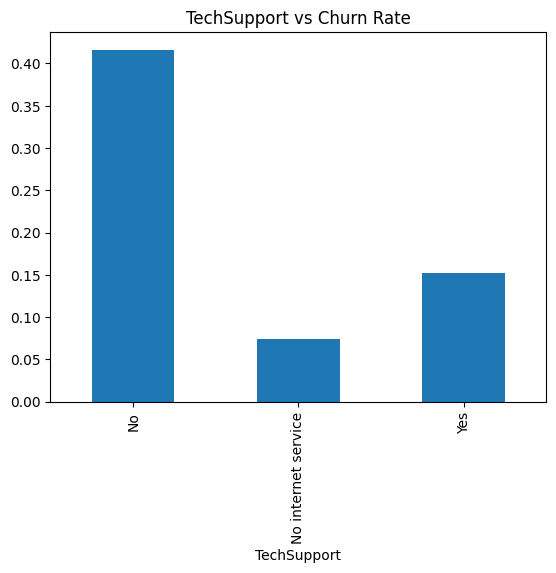

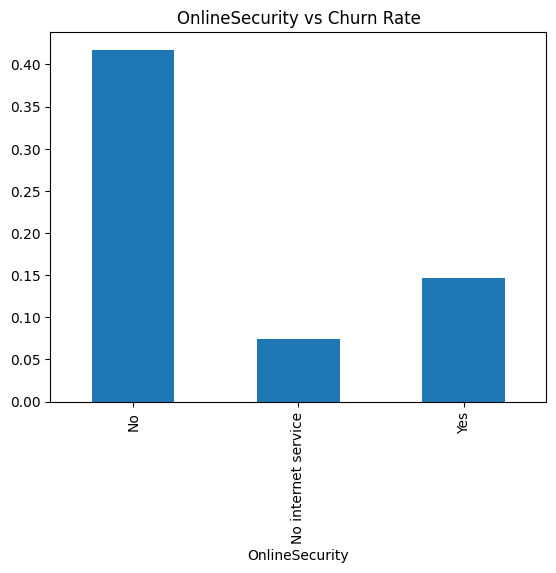

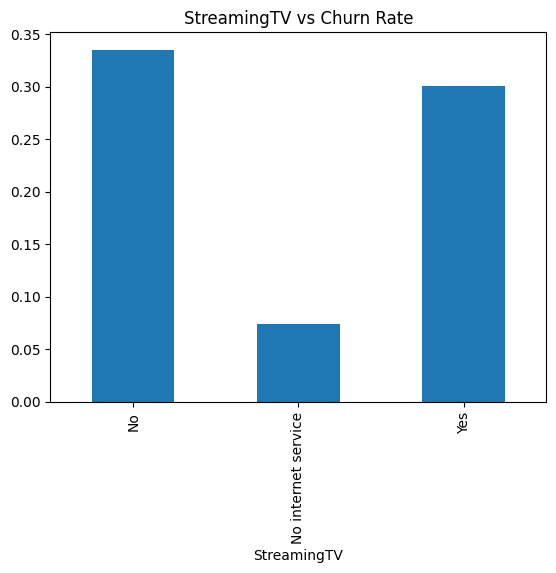

In [31]:
cat_cols = [
    "Contract", "PaymentMethod", "InternetService",
    "TechSupport", "OnlineSecurity", "StreamingTV"
]

for col in cat_cols:
    churn_rate = (
        df.groupby(col)["Churn"]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)["Yes"]
    )
    churn_rate.plot(kind="bar", title=f"{col} vs Churn Rate")
    plt.show()



3. 인사이트


tenure ↔ Churn: 음의 상관 (오래된 고객은 잘 안 떠남)

MonthlyCharges ↔ Churn: 양의 상관 (비싸면 떠날 확률 ↑

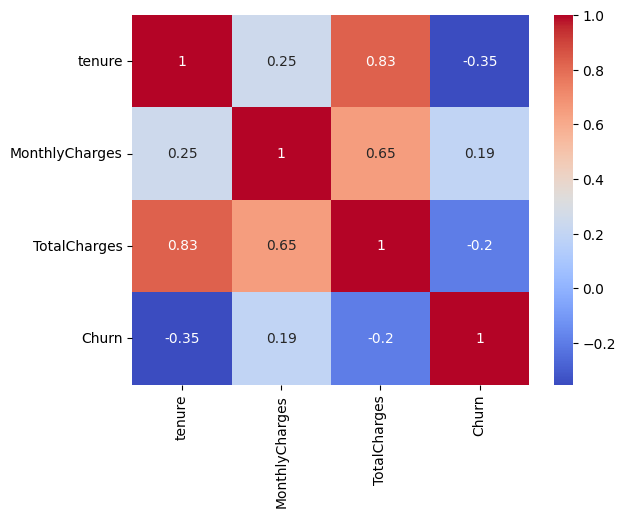

In [ ]:
df_corr = df[["tenure","MonthlyCharges","TotalCharges","Churn"]].copy()
df_corr["Churn"] = df_corr["Churn"].replace({"Yes":1,"No":0})
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm")
plt.show()


**Numerical Features - Analysis**

Understand the distribution of teh numerical features

In [ ]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

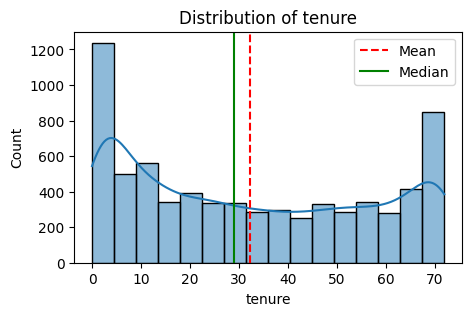

In [ ]:
plot_histogram(df, "tenure")

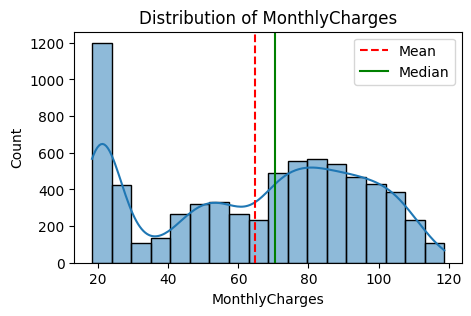

In [ ]:
plot_histogram(df, "MonthlyCharges")

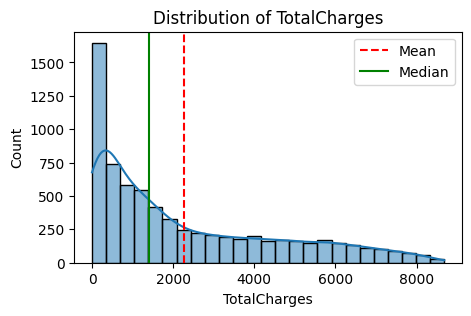

In [ ]:
plot_histogram(df, "TotalCharges")

**Box plot for numerical features**

In [ ]:
def plot_boxplot(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.boxplot(y=df[column_name])
  plt.title(f"Box Plot of {column_name}")
  plt.ylabel(column_name)
  plt.show

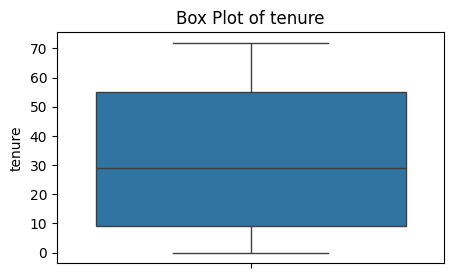

In [ ]:
plot_boxplot(df, "tenure")

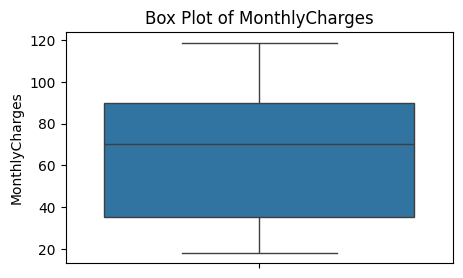

In [ ]:
plot_boxplot(df, "MonthlyCharges")

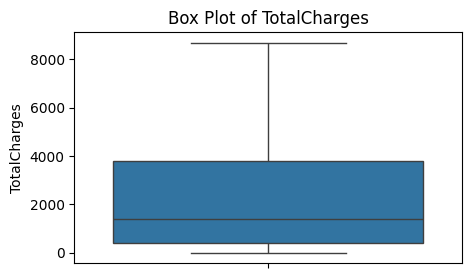

In [ ]:
plot_boxplot(df, "TotalCharges")

**Correlation Heatmap for numerical columns**

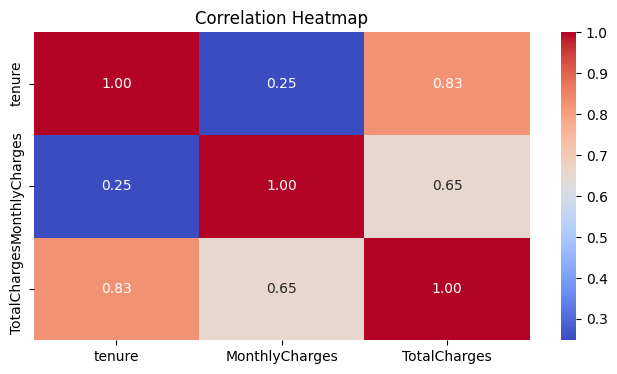

In [ ]:
# correlation matrix - heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Categorical features - Analysis

In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Countplot for categorical columns

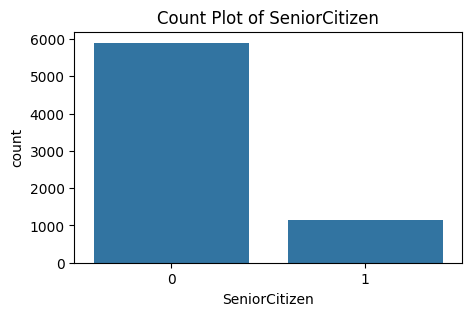

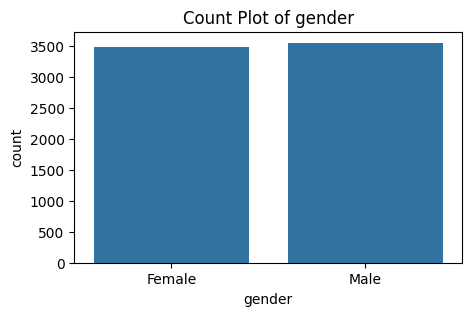

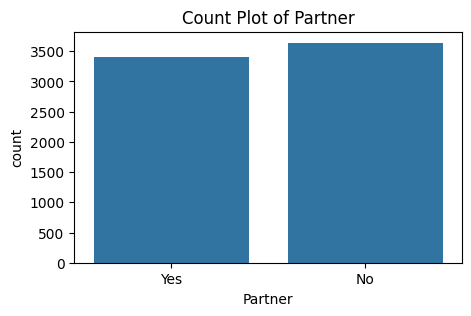

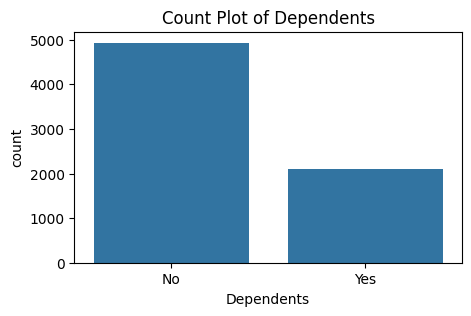

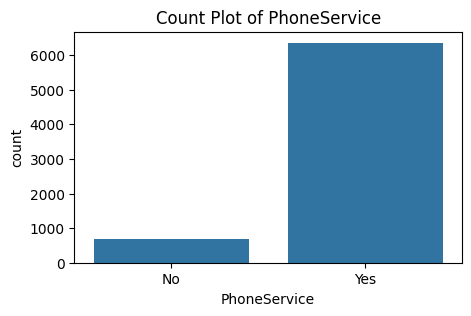

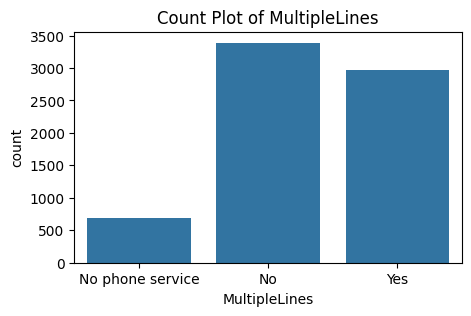

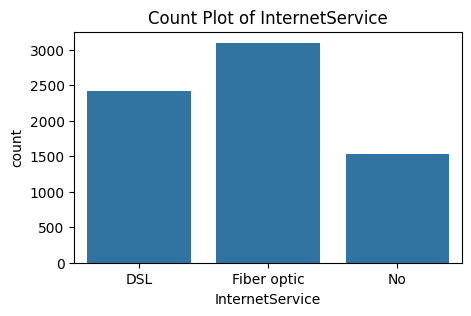

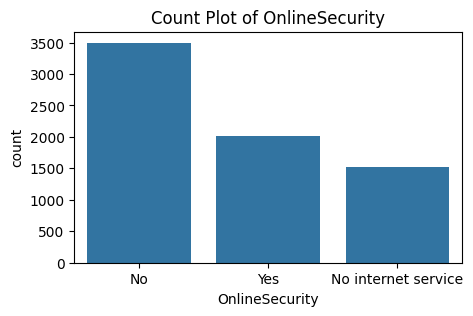

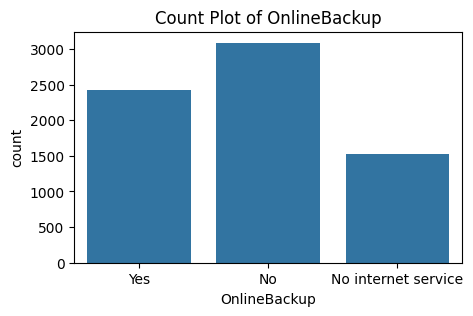

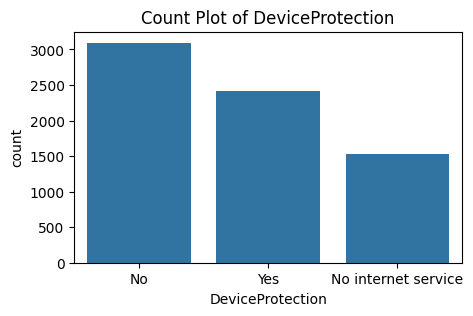

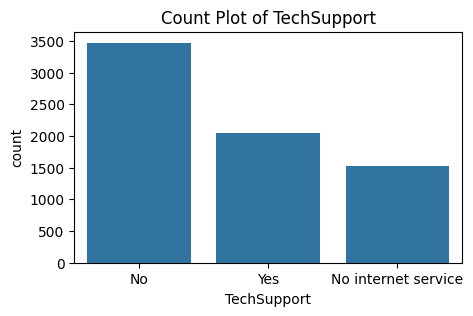

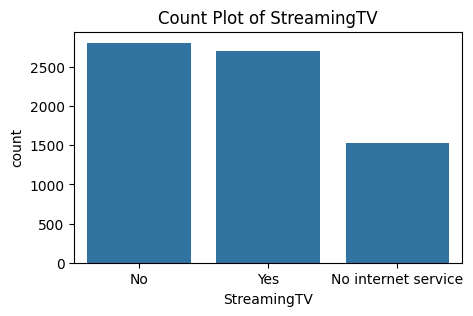

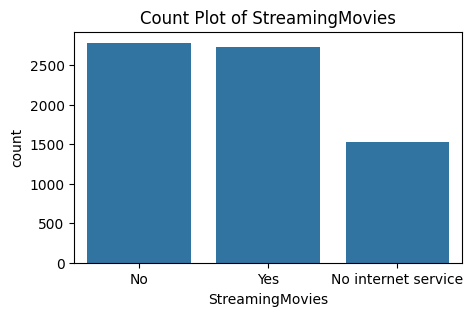

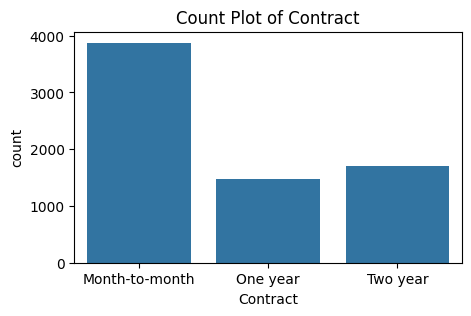

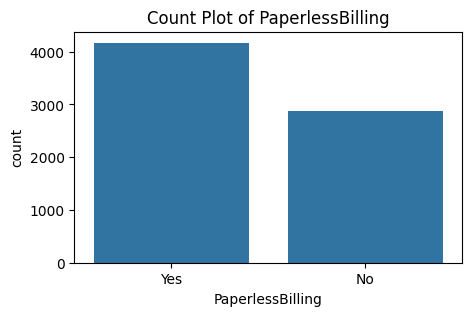

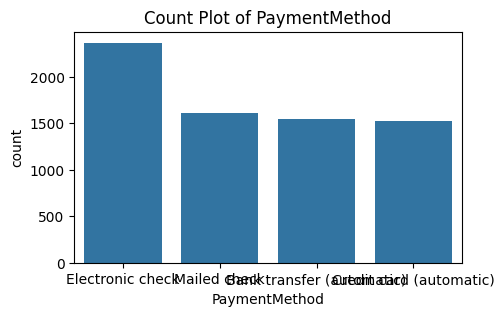

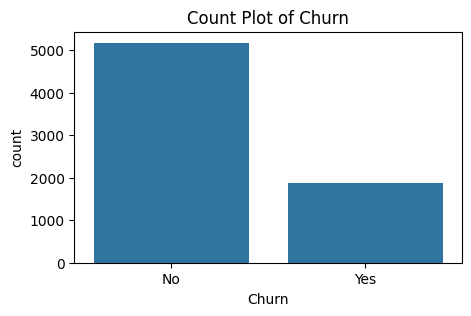

In [ ]:
object_cols = df.select_dtypes(include="object").columns.to_list()

object_cols = ["SeniorCitizen"] + object_cols

for col in object_cols:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[col])
  plt.title(f"Count Plot of {col}")
  plt.show()

**4. Data Preprocessing**

In [ ]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Label encoding of target column

In [ ]:
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

C:\Users\honor\AppData\Local\Temp\ipykernel_27300\2364848822.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


In [ ]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


In [ ]:
print(df["Churn"].value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


Label encoding of categorical fetaures

In [ ]:
# identifying columns with object data type
object_columns = df.select_dtypes(include="object").columns

In [ ]:
print(object_columns)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [ ]:
# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder


# # save the encoders to a pickle file
# with open("encoders.pkl", "wb") as f:
#   pickle.dump(encoders, f)


In [ ]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


**Traianing and test data split**

In [ ]:
# splitting the features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [ ]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(y_train.shape)

(5634,)


In [ ]:
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


Synthetic Minority Oversampling TEchnique (SMOTE)

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
print(y_train_smote.shape)

(8276,)


In [ ]:
print(y_train_smote.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


**5. Model Training**

Training with default hyperparameters

In [ ]:
# dictionary of models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [ ]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("-"*70)

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.78
----------------------------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.84
----------------------------------------------------------------------
Training XGBoost with default parameters
XGBoost cross-validation accuracy: 0.83
----------------------------------------------------------------------


In [ ]:
cv_scores

{'Decision Tree': array([0.68115942, 0.71903323, 0.81752266, 0.84350453, 0.84350453]),
 'Random Forest': array([0.72705314, 0.76676737, 0.90453172, 0.89244713, 0.89848943]),
 'XGBoost': array([0.71074879, 0.75226586, 0.90271903, 0.89123867, 0.89909366])}

Random Forest gives the highest accuracy compared to other models with default parameters

In [ ]:
rfc = RandomForestClassifier(random_state=42)

In [ ]:
rfc.fit(X_train_smote, y_train_smote)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print(y_test.value_counts())

Churn
0    1036
1     373
Name: count, dtype: int64


**6. Model Evaluation**

In [ ]:
# evaluate on test data
y_test_pred = rfc.predict(X_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confsuion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.7771469127040455
Confsuion Matrix:
 [[880 156]
 [158 215]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.58      0.58       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [ ]:
# save the trained model as a pickle file
model_data = {"model": rfc, "features_names": X.columns.tolist()}


with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

**7. Load the saved  model and  build a Predictive System**

In [ ]:
# load teh saved model and the feature names

# with open("customer_churn_model.pkl", "rb") as f:
#   model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]

In [ ]:
print(loaded_model)

RandomForestClassifier(random_state=42)


In [ ]:
print(feature_names)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [ ]:
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}


input_data_df = pd.DataFrame([input_data])

with open("encoders.pkl", "rb") as f:
  encoders = pickle.load(f)


# encode categorical featires using teh saved encoders
for column, encoder in encoders.items():
  input_data_df[column] = encoder.transform(input_data_df[column])

# make a prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)

print(prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

[0]
Prediction: No Churn
Prediciton Probability: [[0.83 0.17]]


In [ ]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

**To do:**
1. Implement Hyperparameter Tuining
2. Try Model Selection
3. Try downsampling
4. Try to address teh overfitting
5. Try Startified k fold CV